In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

In [3]:
def viz_tree(tree_discr, continuous_attributes, tree_outputdir, suffix, saveFig=False):
    import os

    tree_discr.printDiscretizationTrees(round_v=3)

    if type(tree_discr.trees) is dict:
        dot = {}
        for attribute in continuous_attributes:
            dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph()
            if saveFig:
                dot[attribute].render(
                    os.path.join(tree_outputdir, f"tree_{attribute}_{suffix}.pdf")
                )
        dot_show = dot[attribute]
    else:
        dot_show = tree_discr.trees.visualizeTreeDiGraph()
        if saveFig:

            dot_show.render(os.path.join(tree_outputdir, f"tree_{suffix}.pdf"))


def printable_top_k(FP_fm, metric, COL_info, K=3, abbreviations={}, th_redundancy=0):
    from divexplorer_generalized.FP_Divergence import FP_Divergence

    fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

    FP_sorted_i = (
        fp_divergence_i.getDivergence(th_redundancy=th_redundancy)
        .sort_values(
            [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
        )
        .head(K)
    )

    from utils_printable import printable

    COLS = COL_info + [fp_divergence_i.metric, fp_divergence_i.t_value_col]

    FP_print_i = printable(FP_sorted_i[COLS], abbreviations=abbreviations)
    return FP_print_i

In [4]:
out = {}
out_support = {}

In [5]:
# complete_info=False

# if complete_info:
#     COL_info = ["itemsets", "support", "tn", "fp", "fn", "tp"]
# else:
#     COL_info = ["itemsets", "support"]

In [6]:
COL_info_detail = ["itemsets", "support", "tn", "fp", "fn", "tp"]

COL_info = ["itemsets", "support"]

# Parameters

In [7]:
K=3

metric = "d_fpr"

min_sup_divergence=0.05

In [8]:
name_output_dir = "output_compas"

In [9]:
saveFig = False

# Dataset

In [10]:
abbreviations = {
    "age_cat": "age",
    "priors_count": "#prior",
    "Greater than 45": ">45",
    "25 - 45": "25-45",
    "African-American": "Afr-Am",
    "c_charge_degree": "charge",
    "Less than 25": "<25",
    "=>": ">",
    "=<": "<",
    "length_of_stay": "stay",
    "Caucasian": "Cauc",
}

dataset_name = "compas"
risk_class_type = True

from import_datasets import import_process_compas

dfI, class_map = import_process_compas(
    risk_class=risk_class_type, continuous_col=True
)
dfI.reset_index(drop=True, inplace=True)

dfI["predicted"] = dfI["predicted"].replace({"Medium-Low": 0, "High": 1})
true_class_name, pred_class_name = "class", "predicted"
class_and_pred_names = [true_class_name, pred_class_name]
attributes = list(dfI.columns.drop(class_and_pred_names))

dfI = dfI[attributes + class_and_pred_names]
dfI.head()

,c_charge_degree,race,sex,age,priors_count,length_of_stay,class,predicted
0,F,Other,Male,69,0,1.0,0,0
1,F,African-American,Male,34,0,10.0,1,0
2,F,African-American,Male,24,4,1.0,1,0
3,M,Other,Male,44,0,1.0,0,0
4,F,Caucasian,Male,41,14,6.0,1,0


# Domain expert discretization

As in NIPS article:
https://github.com/fair-preprocessing/nips2017/blob/master/compas/code/Generate_Compas_Data.ipynb

## Sup divergence 0.05

In [11]:
min_sup_divergence_05 = 0.05

In [12]:
from import_datasets import discretize

dfI_discr = discretize(dfI, dataset_name=dataset_name)

# ### Extract divergence

from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

fp_diver = FP_DivergenceExplorer(
    dfI_discr, true_class_name=true_class_name, predicted_class_name=pred_class_name
)


FP_fm = fp_diver.getFrequentPatternDivergence(
    min_support=min_sup_divergence_05, metrics=["d_fpr", "d_fnr", "d_error"]
)

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
113,"age=[25-45], #prior>3, race=Afr-Am, sex=Male",0.13,155,69,268,302,0.220,7.1
166,"age=[25-45], charge=F, #prior>3, race=Afr-Am, sex=Male",0.10,109,48,194,237,0.217,6.0
255,"stay=1w-3M, #prior>3, sex=Male",0.06,73,32,149,135,0.216,4.9


In [13]:
from divexplorer_generalized.FP_Divergence import FP_Divergence


out["default"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

In [14]:
out["default"]

,itemsets,sup,Δ_fpr,t_fp
113,"age=[25-45], #prior>3, race=Afr-Am, sex=Male",0.13,0.220,7.1
166,"age=[25-45], charge=F, #prior>3, race=Afr-Am, sex=Male",0.10,0.217,6.0
255,"stay=1w-3M, #prior>3, sex=Male",0.06,0.216,4.9


In [15]:
out_support.setdefault(min_sup_divergence_05, {})["default"] = out["default"].head(1)

## Sup divergence 0.025

In [16]:
min_sup_divergence_025 = 0.025

In [17]:
from import_datasets import discretize

dfI_discr = discretize(dfI, dataset_name=dataset_name)

# ### Extract divergence

from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

fp_diver = FP_DivergenceExplorer(
    dfI_discr, true_class_name=true_class_name, predicted_class_name=pred_class_name
)


FP_fm = fp_diver.getFrequentPatternDivergence(
    min_support=min_sup_divergence_025, metrics=["d_fpr", "d_fnr", "d_error"]
)

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
473,"age=[25-45], stay=1w-3M, #prior>3, race=Afr-Am, sex=Male",0.03,31,19,69,80,0.292,4.4
521,"age<25, charge=F, stay=1w-3M",0.03,37,22,59,53,0.285,4.7
433,"age=[25-45], stay=1w-3M, #prior>3, race=Afr-Am",0.04,33,19,77,90,0.277,4.3


In [18]:
from divexplorer_generalized.FP_Divergence import FP_Divergence


out["default"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

In [19]:
out["default"]

,itemsets,sup,Δ_fpr,t_fp
473,"age=[25-45], stay=1w-3M, #prior>3, race=Afr-Am, sex=Male",0.03,0.292,4.4
521,"age<25, charge=F, stay=1w-3M",0.03,0.285,4.7
433,"age=[25-45], stay=1w-3M, #prior>3, race=Afr-Am",0.04,0.277,4.3


In [20]:
out_support.setdefault(min_sup_divergence_025, {})["default"] = out["default"].head(1)

## Sup divergence 0.01

In [21]:
min_sup_divergence_01 = 0.01

In [22]:
from import_datasets import discretize

dfI_discr = discretize(dfI, dataset_name=dataset_name)

# ### Extract divergence

from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

fp_diver = FP_DivergenceExplorer(
    dfI_discr, true_class_name=true_class_name, predicted_class_name=pred_class_name
)


FP_fm = fp_diver.getFrequentPatternDivergence(
    min_support=min_sup_divergence_01, metrics=["d_fpr", "d_fnr", "d_error"]
)

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
710,"age<25, charge=F, #prior>3",0.02,5,12,30,59,0.618,5.7
754,"age<25, charge=F, #prior>3, sex=Male",0.02,5,11,28,54,0.599,5.3
656,"age<25, #prior>3, sex=Male",0.02,7,15,35,63,0.594,6.1


In [23]:
from divexplorer_generalized.FP_Divergence import FP_Divergence


FP_fm_print = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

In [24]:
out_support.setdefault(min_sup_divergence_01, {})["default"] = FP_fm_print.head(1)

In [25]:
FP_fm_print

,itemsets,sup,Δ_fpr,t_fp
710,"age<25, charge=F, #prior>3",0.02,0.618,5.7
754,"age<25, charge=F, #prior>3, sex=Male",0.02,0.599,5.3
656,"age<25, #prior>3, sex=Male",0.02,0.594,6.1


# Tree divergence - FPR

In [26]:
min_support_tree=0.1

In [27]:
show_fig = True

In [28]:
import os


tree_outputdir = os.path.join(".", "output", "figures", "compas", "tree")
if saveFig:
    from pathlib import Path

    Path(tree_outputdir).mkdir(parents=True, exist_ok=True)

In [29]:
cols_c = ["class", "predicted"]
continuous_attributes = ["priors_count", "length_of_stay", "age"]

## Tree divergence - weighted divergence

In [30]:
type_criterion="weighted_sum_abs_reference_s"

type_experiment = "one_at_time"

In [31]:
df_analyze = dfI.copy()

In [32]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion=type_criterion,
    # minimal_gain = 0.0015
)

In [33]:
tree_discr.printDiscretizationTrees(round_v=3, show_condition=True)

priors_count
 root s=1.000 --> d_fpr=0.000
         priors_count<=3 s=0.707 --> d_fpr=-0.029
                 priors_count<=0 s=0.338 --> d_fpr=-0.040
                 priors_count>0 s=0.369 --> d_fpr=-0.015
                         priors_count<=1 s=0.183 --> d_fpr=-0.018
                         priors_count>1 s=0.186 --> d_fpr=-0.012
         priors_count>3 s=0.293 --> d_fpr=0.131
                 priors_count<=8 s=0.179 --> d_fpr=0.065
                 priors_count>8 s=0.115 --> d_fpr=0.295

length_of_stay
 root s=1.000 --> d_fpr=0.000
         length_of_stay<=2.0 s=0.663 --> d_fpr=-0.022
                 length_of_stay<=0.0 s=0.113 --> d_fpr=-0.040
                 length_of_stay>0.0 s=0.550 --> d_fpr=-0.018
                         length_of_stay<=1.0 s=0.438 --> d_fpr=-0.021
                         length_of_stay>1.0 s=0.113 --> d_fpr=-0.003
         length_of_stay>2.0 s=0.337 --> d_fpr=0.061
                 length_of_stay<=33.0 s=0.230 --> d_fpr=0.018
                        

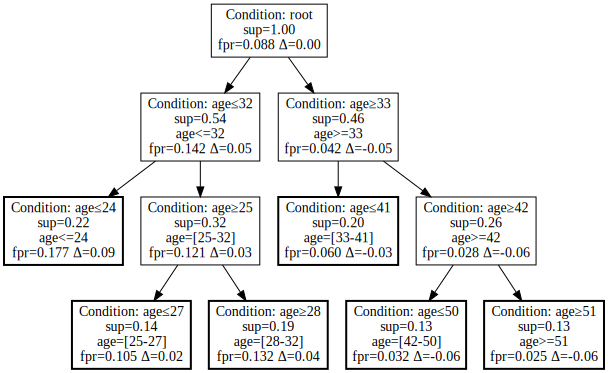

In [34]:
if type(tree_discr.trees) is dict:
    dot = {}
    for attribute in continuous_attributes:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph(all_info = False)
dot[attribute]

./output/figures/compas/tree/tree_priors_count_one_at_time_weighted_sum_abs_reference_s_sd_0.1_d_fpr


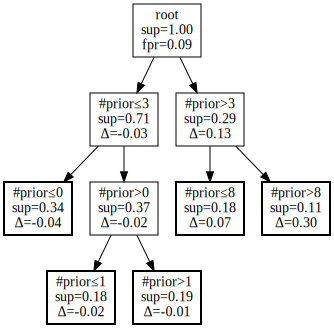

In [35]:
if type(tree_discr.trees) is dict:
    dot = {}
    for attribute in continuous_attributes:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph(abbreviations=abbreviations, all_info = False, show_condition=True)
suffix=f"{type_experiment}_{type_criterion}_sd_{min_support_tree}_{metric}"
saveFig = True
attribute = "priors_count"
if saveFig:
    dot[attribute].render(
       os.path.join(tree_outputdir, f"tree_{attribute}_{suffix}")
                )
print(os.path.join(tree_outputdir, f"tree_{attribute}_{suffix}"))       
dot[attribute]

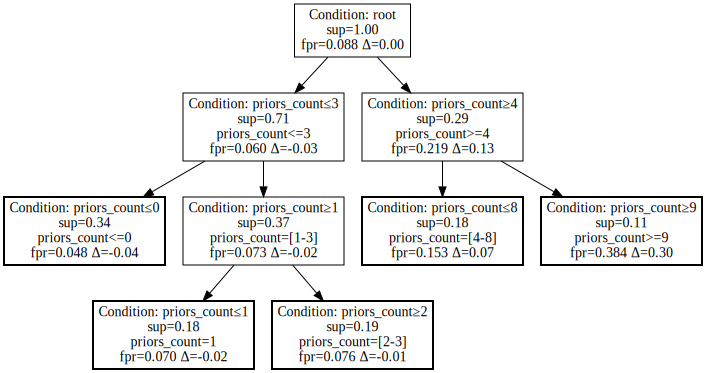

In [36]:
if type(tree_discr.trees) is dict:
    dot = {}
    for attribute in tree_discr.trees:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph(all_info = False)
else:
    dot_show = tree_discr.trees.visualizeTreeDiGraph()
dot["priors_count"]

In [37]:
if show_fig:
    viz_tree(
        tree_discr,
        continuous_attributes,
        tree_outputdir,
        suffix=f"{type_experiment}_{type_criterion}_sd_{min_support_tree}_{metric}",
        saveFig=saveFig,
    )

priors_count
 root s=1.000 --> d_fpr=0.000
         priors_count<=3 s=0.707 --> d_fpr=-0.029
                 priors_count<=0 s=0.338 --> d_fpr=-0.040
                 priors_count>=1 s=0.369 --> d_fpr=-0.015
                         priors_count<=1 s=0.183 --> d_fpr=-0.018
                         priors_count>=2 s=0.186 --> d_fpr=-0.012
         priors_count>=4 s=0.293 --> d_fpr=0.131
                 priors_count<=8 s=0.179 --> d_fpr=0.065
                 priors_count>=9 s=0.115 --> d_fpr=0.295

length_of_stay
 root s=1.000 --> d_fpr=0.000
         length_of_stay<=2.0 s=0.663 --> d_fpr=-0.022
                 length_of_stay<=0.0 s=0.113 --> d_fpr=-0.040
                 length_of_stay>=1.0 s=0.550 --> d_fpr=-0.018
                         length_of_stay<=1.0 s=0.438 --> d_fpr=-0.021
                         length_of_stay>=2.0 s=0.113 --> d_fpr=-0.003
         length_of_stay>=3.0 s=0.337 --> d_fpr=0.061
                 length_of_stay<=33.0 s=0.230 --> d_fpr=0.018
                 

In [38]:
considerOnlyContinuos = True
if considerOnlyContinuos:
    for k in list(generalization_dict.keys()):
        if k not in continuous_attributes:
            generalization_dict.pop(k, None)

### Sup divergence = 0.05

In [39]:
min_sup_divergence_05 = 0.05

In [40]:
complete_info=False

if complete_info:
    COL_info = ["itemsets", "support", "tn", "fp", "fn", "tp"]
else:
    COL_info = ["itemsets", "support"]

#### Extract divergence 

##### Without gen

In [41]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_05,
    apply_generalization=False,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)

if type_experiment not in out:
    out[type_experiment] = {}
    
    
display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

out[type_experiment]["without_gen"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
106,"#prior>=9, race=Afr-Am",0.09,68,56,149,260,0.363,8.2
118,"#prior>=9, race=Afr-Am, sex=Male",0.08,63,49,142,237,0.349,7.5
151,"charge=F, #prior>=9, race=Afr-Am",0.07,54,41,110,208,0.343,6.8


In [42]:
out[type_experiment]["without_gen"]

,itemsets,sup,Δ_fpr,t_fp
106,"#prior>=9, race=Afr-Am",0.09,0.363,8.2
118,"#prior>=9, race=Afr-Am, sex=Male",0.08,0.349,7.5
151,"charge=F, #prior>=9, race=Afr-Am",0.07,0.343,6.8


In [43]:
print(out[type_experiment]["without_gen"].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                         itemsets &   sup &  Δ\_fpr &  t\_fp \\
\midrule
           \#prior>=9, race=Afr-Am &  0.09 &  0.363 &   8.2 \\
 \#prior>=9, race=Afr-Am, sex=Male &  0.08 &  0.349 &   7.5 \\
 charge=F, \#prior>=9, race=Afr-Am &  0.07 &  0.343 &   6.8 \\
\bottomrule
\end{tabular}



In [44]:
out_support.setdefault(min_sup_divergence_05, {}).setdefault(type_experiment, {})["without_gen"] = out[type_experiment]["without_gen"].head(1)

#### Extract divergence 

##### With gen

In [45]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_05,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)
    
    
    
display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

out[type_experiment]["with_gen"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
1052,"age<=32, stay>=3.0, #prior>=4, sex=Male",0.06,40,35,123,174,0.378,6.7
595,"#prior>=9, race=Afr-Am",0.09,68,56,149,260,0.363,8.2
682,"#prior>=9, race=Afr-Am, sex=Male",0.08,63,49,142,237,0.349,7.5


In [46]:
out[type_experiment]["with_gen"]

,itemsets,sup,Δ_fpr,t_fp
1052,"age<=32, stay>=3.0, #prior>=4, sex=Male",0.06,0.378,6.7
595,"#prior>=9, race=Afr-Am",0.09,0.363,8.2
682,"#prior>=9, race=Afr-Am, sex=Male",0.08,0.349,7.5


In [47]:
print(out[type_experiment]["with_gen"].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                                itemsets &   sup &  Δ\_fpr &  t\_fp \\
\midrule
 age<=32, stay>=3.0, \#prior>=4, sex=Male &  0.06 &  0.378 &   6.7 \\
                  \#prior>=9, race=Afr-Am &  0.09 &  0.363 &   8.2 \\
        \#prior>=9, race=Afr-Am, sex=Male &  0.08 &  0.349 &   7.5 \\
\bottomrule
\end{tabular}



In [48]:
out_support.setdefault(min_sup_divergence_05, {}).setdefault(type_experiment, {})["with_gen"] = out[type_experiment]["with_gen"].head(1)

### Sup divergence = 0.025

In [49]:
min_sup_divergence_025 = 0.025

#### Extract divergence 

##### Without gen

In [50]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_025,
    apply_generalization=False,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm_pr = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
453,"age=[28-32], #prior>=9, sex=Male",0.03,9,19,51,83,0.590,6.8
388,"age=[28-32], #prior>=9",0.03,11,23,57,95,0.588,7.4
413,"stay>=34.0, #prior>=9",0.03,22,19,47,86,0.375,5.0


In [51]:
FP_fm_pr

,itemsets,sup,Δ_fpr,t_fp
453,"age=[28-32], #prior>=9, sex=Male",0.03,0.590,6.8
388,"age=[28-32], #prior>=9",0.03,0.588,7.4
413,"stay>=34.0, #prior>=9",0.03,0.375,5.0


In [52]:
out_support.setdefault(min_sup_divergence_025, {}).setdefault(type_experiment, {})["without_gen"] = FP_fm_pr.head(1)

#### Extract divergence 

##### With gen

In [53]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_025,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)

    
display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm_pr = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
2416,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,9,22,55,116,0.621,7.7
2267,"age<=32, #prior>=9, race=Afr-Am, sex=Male",0.03,9,20,53,130,0.601,7.1
2229,"age<=32, charge=F, #prior>=9, sex=Male",0.03,10,22,55,128,0.599,7.4


In [54]:
FP_fm_pr

,itemsets,sup,Δ_fpr,t_fp
2416,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7
2267,"age<=32, #prior>=9, race=Afr-Am, sex=Male",0.03,0.601,7.1
2229,"age<=32, charge=F, #prior>=9, sex=Male",0.03,0.599,7.4


In [55]:
out_support.setdefault(min_sup_divergence_025, {}).setdefault(type_experiment, {})["with_gen"] = FP_fm_pr.head(1)

### Sup divergence = 0.01

In [56]:
min_sup_divergence_01 = 0.01

#### Extract divergence 

##### Without gen

In [57]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_01,
    apply_generalization=False,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm_pr = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
848,"age<=24, charge=F, #prior=[4-8]",0.02,4,12,30,47,0.662,6.2
571,"age=[28-32], charge=F, #prior>=9, sex=Male",0.02,6,17,40,71,0.651,7.2
921,"age<=24, charge=F, #prior=[4-8], sex=Male",0.01,4,11,28,42,0.645,5.7


In [58]:
FP_fm_pr

,itemsets,sup,Δ_fpr,t_fp
848,"age<=24, charge=F, #prior=[4-8]",0.02,0.662,6.2
571,"age=[28-32], charge=F, #prior>=9, sex=Male",0.02,0.651,7.2
921,"age<=24, charge=F, #prior=[4-8], sex=Male",0.01,0.645,5.7


In [59]:
out_support.setdefault(min_sup_divergence_01, {}).setdefault(type_experiment, {})["without_gen"] = FP_fm_pr.head(1)

#### Extract divergence 

##### With gen

In [60]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence_01,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
)

    
display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm_pr = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
3697,"age=[25-32], stay>=3.0, #prior>=9",0.02,3,15,37,83,0.745,8.1
5374,"age=[28-32], stay>=3.0, #prior>=9",0.02,2,10,30,53,0.745,6.6
4486,"age=[25-32], charge=F, stay>=3.0, #prior>=9",0.02,3,14,30,68,0.735,7.7


In [61]:
FP_fm_pr

,itemsets,sup,Δ_fpr,t_fp
3697,"age=[25-32], stay>=3.0, #prior>=9",0.02,0.745,8.1
5374,"age=[28-32], stay>=3.0, #prior>=9",0.02,0.745,6.6
4486,"age=[25-32], charge=F, stay>=3.0, #prior>=9",0.02,0.735,7.7


In [62]:
printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations).head(1).T.to_dict()

{3697: {'itemsets': 'age=[25-32], stay>=3.0, #prior>=9',
  'sup': 0.02,
  'tn': 3,
  'fp': 15,
  'fn': 37,
  'tp': 83,
  'Δ_fpr': 0.745,
  't_fp': 8.1}}

In [63]:
out_support.setdefault(min_sup_divergence_01, {}).setdefault(type_experiment, {})["with_gen"] = FP_fm_pr.head(1)

# Quantile 

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:

def check_ranges_validity(dfI_discr_quantile, bins, continuous_attributes):
    for cont_attr in continuous_attributes:
        print(
            cont_attr,
            len(dfI_discr_quantile[cont_attr].value_counts()),
            dict(dfI_discr_quantile[cont_attr].value_counts()),
            sum(dfI_discr_quantile[cont_attr].value_counts().values),
        )
        if len(dfI_discr_quantile[cont_attr].value_counts()) != bins:
            print(dict(dfI_discr_quantile[cont_attr].value_counts()))
            raise ValueError


In [66]:
bins = 5

In [67]:
from import_datasets import discretize

dfI_discr_quantile = discretize(
    dfI, bins=bins, strategy="quantile", adaptive=True
)

# TODO
dfI_discr_quantile[true_class_name] = dfI_discr_quantile[
    true_class_name
].astype(int)
dfI_discr_quantile[pred_class_name] = dfI_discr_quantile[
    pred_class_name
].astype(int)

check_ranges_validity(dfI_discr_quantile, bins, continuous_attributes)

priors_count 5 {'<=1': 3214, '>7': 853, '(2-4]': 783, '(1-2]': 681, '(4-7]': 641} 6172
length_of_stay 5 {'<=1': 3397, '>24': 870, '(4-24]': 833, '(1-2]': 696, '(2-4]': 376} 6172
age 5 {'<=24': 1347, '(24-29]': 1334, '>45': 1201, '(29-35]': 1168, '(35-45]': 1122} 6172


In [68]:
# ### Extract divergence

from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

fp_diver = FP_DivergenceExplorer(
    dfI_discr_quantile,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
)

FP_fm = fp_diver.getFrequentPatternDivergence(
                min_support=0.01,
                metrics=["d_fpr", "d_fnr", "d_accuracy", "d_error"],
            )

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm.sort_values("d_fpr", ascending = False).head()

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
567,"age=(24-29], #prior>7, race=Afr-Am, sex=Male",0.02,7,10,40,85,0.500,4.4
529,"age=(24-29], #prior>7, race=Afr-Am",0.02,8,11,42,90,0.491,4.6
560,"age=(29-35], charge=F, #prior>7, race=Afr-Am",0.02,14,19,33,78,0.487,5.8


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,fnr,accuracy,error,d_fnr,d_fpr,d_accuracy,d_error,t_value_fp,t_value_fn,t_value_tp_tn,t_value_fp_fn
567,0.023007,"(sex=Male, priors_count=>7, race=African-American, age=(24-29])",7,10,40,85,4,142.0,0.588235,0.320000,0.647887,0.352113,-0.378469,0.499921,0.013895,-0.013895,4.437526,8.892988,0.295726,0.295726
529,0.024465,"(priors_count=>7, race=African-American, age=(24-29])",8,11,42,90,3,151.0,0.578947,0.318182,0.649007,0.350993,-0.380287,0.490633,0.015014,-0.015014,4.571741,9.183433,0.336206,0.336206
560,0.023331,"(priors_count=>7, age=(29-35], race=African-American, c_charge_degree=F)",14,19,33,78,4,144.0,0.575758,0.297297,0.638889,0.361111,-0.401172,0.487444,0.004897,-0.004897,5.844195,9.070071,0.075687,0.075687
992,0.012638,"(race=African-American, priors_count=(2-4], age=<=24, c_charge_degree=F)",7,9,29,33,4,78.0,0.562500,0.467742,0.512821,0.487179,-0.230727,0.474186,-0.121172,0.121172,4.092776,3.673344,2.173561,2.173561
431,0.029974,"(priors_count=>7, age=(29-35], c_charge_degree=F)",19,24,47,95,3,185.0,0.558140,0.330986,0.616216,0.383784,-0.367483,0.469826,-0.017776,0.017776,6.359932,9.103601,0.526884,0.526884


# Uniform 

In [69]:

def check_ranges_validity(dfI_discr_quantile, bins, continuous_attributes):
    for cont_attr in continuous_attributes:
        print(
            cont_attr,
            len(dfI_discr_quantile[cont_attr].value_counts()),
            dict(dfI_discr_quantile[cont_attr].value_counts()),
            sum(dfI_discr_quantile[cont_attr].value_counts().values),
        )
        if len(dfI_discr_quantile[cont_attr].value_counts()) != bins:
            print(dict(dfI_discr_quantile[cont_attr].value_counts()))
            raise ValueError


In [70]:
bins = 5

In [71]:
from import_datasets import discretize

dfI_discr_uniform = discretize(
            dfI, bins=bins, strategy="uniform", adaptive=True
        )

# TODO
dfI_discr_uniform[true_class_name] = dfI_discr_uniform[true_class_name].astype(
    int
)
dfI_discr_uniform[pred_class_name] = dfI_discr_uniform[pred_class_name].astype(
    int
)

check_ranges_validity(dfI_discr_uniform, bins, continuous_attributes)

priors_count 5 {'<=8': 5463, '(8-15]': 497, '(15-23]': 169, '(23-30]': 36, '>30': 7} 6172
length_of_stay 5 {'<=160': 6029, '(160-320]': 115, '(320-480]': 20, '(480-640]': 6, '>640': 2} 6172
age 5 {'<=34': 3698, '(34-49]': 1601, '(49-65]': 793, '(65-80]': 78, '>80': 2} 6172


In [72]:
# ### Extract divergence

from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

fp_diver = FP_DivergenceExplorer(
    dfI_discr_uniform,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
)


FP_fm = fp_diver.getFrequentPatternDivergence(
                min_support=0.01,
                metrics=["d_fpr", "d_fnr", "d_accuracy", "d_error"],
            )

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

FP_fm.sort_values("d_fpr", ascending = False).head()

,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
631,"age<=34, #prior=(15-23]",0.01,0,6,11,48,0.912,7.1
360,"age<=34, #prior=(8-15], race=Afr-Am",0.03,14,21,59,117,0.512,6.3
408,"age<=34, charge=F, #prior=(8-15], race=Afr-Am",0.03,13,19,47,90,0.505,6.0


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,fnr,accuracy,error,d_fnr,d_fpr,d_accuracy,d_error,t_value_fp,t_value_fn,t_value_tp_tn,t_value_fp_fn
632,0.010369,"(sex=Male, age=<=34, priors_count=(15-23])",0,6,11,47,3,64.0,1.00000,0.189655,0.734375,0.265625,-0.508814,0.911686,0.100383,-0.100383,7.126897,9.594116,1.704426,1.704426
631,0.010531,"(age=<=34, priors_count=(15-23])",0,6,11,48,2,65.0,1.00000,0.186441,0.738462,0.261538,-0.512029,0.911686,0.104469,-0.104469,7.126897,9.792861,1.800210,1.800210
360,0.034187,"(race=African-American, age=<=34, priors_count=(8-15])",14,21,59,117,3,211.0,0.60000,0.335227,0.620853,0.379147,-0.363242,0.511686,-0.013139,0.013139,6.341596,9.930738,0.421688,0.421688
365,0.032566,"(length_of_stay=<=160, race=African-American, age=<=34, priors_count=(8-15])",14,21,57,109,4,201.0,0.60000,0.343373,0.611940,0.388060,-0.355096,0.511686,-0.022052,0.022052,6.341596,9.394932,0.666377,0.666377
408,0.027382,"(race=African-American, age=<=34, priors_count=(8-15], c_charge_degree=F)",13,19,47,90,4,169.0,0.59375,0.343066,0.609467,0.390533,-0.355404,0.505436,-0.024525,0.024525,5.996141,8.587564,0.682918,0.682918


In [73]:
printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations).head(1).T.to_dict()

{631: {'itemsets': 'age<=34, #prior=(15-23]',
  'sup': 0.01,
  'tn': 0,
  'fp': 6,
  'fn': 11,
  'tp': 48,
  'Δ_fpr': 0.912,
  't_fp': 7.1}}

# All attributes

## Tree divergence - weighted divergence

In [74]:
type_criterion="weighted_sum_abs_reference_s"

type_experiment = "all_attributes"

In [75]:
df_analyze = dfI.copy()

In [76]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=0.1,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion=type_criterion,
    # minimal_gain = 0.0015
)

False


In [77]:
tree_discr.printDiscretizationTrees(round_v=3, show_condition=True)

Type splitting: None
 root s=1.000 --> d_fpr=0.000
         age<=32 s=0.542 --> d_fpr=0.054
                 priors_count<=3 s=0.399 --> d_fpr=0.016
                         age<=24 s=0.196 --> d_fpr=0.069
                         age>24 s=0.203 --> d_fpr=-0.023
                 priors_count>3 s=0.143 --> d_fpr=0.291
         age>32 s=0.458 --> d_fpr=-0.047
                 priors_count<=3 s=0.308 --> d_fpr=-0.071
                         race=African-American s=0.101 --> d_fpr=-0.048
                         race!=African-American s=0.207 --> d_fpr=-0.081
                                 priors_count<=0 s=0.106 --> d_fpr=-0.088
                                 priors_count>0 s=0.101 --> d_fpr=-0.072
                 priors_count>3 s=0.150 --> d_fpr=0.041


In [78]:
tree_discr.printDiscretizationTrees(round_v=3)

Type splitting: None
 root s=1.000 --> d_fpr=0.000
         age<=32 s=0.542 --> d_fpr=0.054
                 priors_count<=3 s=0.399 --> d_fpr=0.016
                         age<=24 s=0.196 --> d_fpr=0.069
                         age>=25 s=0.203 --> d_fpr=-0.023
                 priors_count>=4 s=0.143 --> d_fpr=0.291
         age>=33 s=0.458 --> d_fpr=-0.047
                 priors_count<=3 s=0.308 --> d_fpr=-0.071
                         race=African-American s=0.101 --> d_fpr=-0.048
                         race!=African-American s=0.207 --> d_fpr=-0.081
                                 priors_count<=0 s=0.106 --> d_fpr=-0.088
                                 priors_count>=1 s=0.101 --> d_fpr=-0.072
                 priors_count>=4 s=0.150 --> d_fpr=0.041


In [79]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.01,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    allow_overalp= True,
    type_experiment=type_experiment
)

if type_experiment not in out:
    out[type_experiment] = {}
    
    
display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

out[type_experiment]["with_gen"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

E allow_overalp True


,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
982,"age<=24, charge=F, #prior>=4",0.02,5,12,30,59,0.618,5.7
1025,"age<=24, charge=F, #prior>=4, sex=Male",0.02,5,11,28,54,0.599,5.3
923,"age<=24, #prior>=4, sex=Male",0.02,7,15,35,63,0.594,6.1


./output/figures/compas/tree/tree_all_attributes_weighted_sum_abs_reference_s_sd_0.1_st0.05_d_fpr


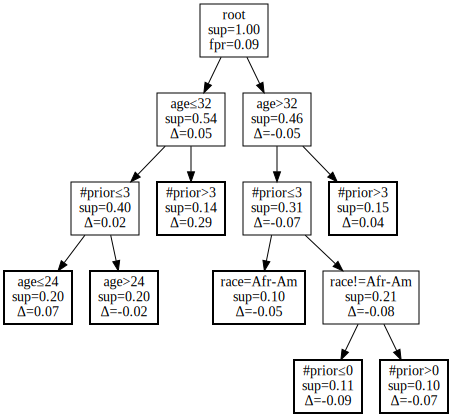

In [80]:
dot = tree_discr.trees.visualizeTreeDiGraph(abbreviations=abbreviations, all_info = False, show_condition=True)

suffix=f"{type_experiment}_{type_criterion}_sd_{min_support_tree}_st{min_sup_divergence}_{metric}"
saveFig = True

if saveFig:
    dot.render(
       os.path.join(tree_outputdir, f"tree_{suffix}")
                )
print(os.path.join(tree_outputdir, f"tree_{suffix}"))       
dot

## Tree divergence - entropy - all attributes

In [81]:
type_criterion="entropy"

type_experiment = "all_attributes"

In [82]:
df_analyze = dfI.copy()

In [83]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion=type_criterion,
    # minimal_gain = 0.0015
)

False


In [84]:
tree_discr.printDiscretizationTrees(round_v=3)

Type splitting: None
 root s=1.000 --> d_fpr=0.000
         priors_count<=3 s=0.707 --> d_fpr=-0.029
                 age<=25 s=0.228 --> d_fpr=0.058
                         priors_count<=0 s=0.113 --> d_fpr=0.021
                         priors_count>=1 s=0.115 --> d_fpr=0.114
                 age>=26 s=0.478 --> d_fpr=-0.057
                         age<=37 s=0.253 --> d_fpr=-0.035
                                 race=African-American s=0.118 --> d_fpr=-0.005
                                 race!=African-American s=0.135 --> d_fpr=-0.061
                         age>=38 s=0.225 --> d_fpr=-0.078
                                 priors_count<=0 s=0.113 --> d_fpr=-0.087
                                 priors_count>=1 s=0.113 --> d_fpr=-0.068
         priors_count>=4 s=0.293 --> d_fpr=0.131
                 age<=32 s=0.143 --> d_fpr=0.291
                 age>=33 s=0.150 --> d_fpr=0.041


In [92]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analyze,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.1,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    allow_overalp= True,
    type_experiment=type_experiment
)

if type_experiment not in out:
    out[type_experiment] = {}
    
cols = ['itemsets', "support", "d_fpr", "t_value_fp"]
display(FP_fm.sort_values(metric, ascending = False)[cols].head(3))
display(FP_fm.sort_values([ metric, "support"], ascending = [  False, True])[cols].head(20))

display(printable_top_k(
    FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

out[type_experiment]["with_gen"] = printable_top_k(
    FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
)

,itemsets,support,d_fpr,t_value_fp
446,"(age=<=32, priors_count=>=4, race=African-American)",0.102074,0.320137,7.807960
303,"(sex=Male, age=<=32, priors_count=>=4)",0.127025,0.310593,8.590700
401,"(age=<=32, priors_count=>=4, c_charge_degree=F)",0.109365,0.302712,7.784544


,itemsets,support,d_fpr,t_value_fp
446,"(age=<=32, priors_count=>=4, race=African-American)",0.102074,0.320137,7.807960
303,"(sex=Male, age=<=32, priors_count=>=4)",0.127025,0.310593,8.590700
401,"(age=<=32, priors_count=>=4, c_charge_degree=F)",0.109365,0.302712,7.784544
244,"(age=<=32, priors_count=>=4)",0.143065,0.291316,8.807091
418,"(age=<=32, priors_count=>=4, age=[26-37])",0.106773,0.264979,7.196813
419,"(age=<=32, age=>=26, priors_count=>=4)",0.106773,0.264979,7.196813
420,"(age=<=32, age=>=26, priors_count=>=4, age=[26-37])",0.106773,0.264979,7.196813
459,"(race=African-American, priors_count=>=4, sex=Male, age=>=26, age=[26-37])",0.100940,0.249109,6.765467
461,"(sex=Male, race=African-American, priors_count=>=4, age=[26-37])",0.100940,0.249109,6.765467
353,"(race=African-American, priors_count=>=4, age=[26-37])",0.113577,0.243292,7.193759


,itemsets,sup,tn,fp,fn,tp,Δ_fpr,t_fp
446,"age<=32, #prior>=4, race=Afr-Am",0.10,84,58,207,281,0.320,7.8
303,"age<=32, #prior>=4, sex=Male",0.13,110,73,275,326,0.311,8.6
401,"age<=32, charge=F, #prior>=4",0.11,95,61,231,288,0.303,7.8


./output/figures/compas/tree/tree_all_attributes_entropy_sd_0.1_d_fpr


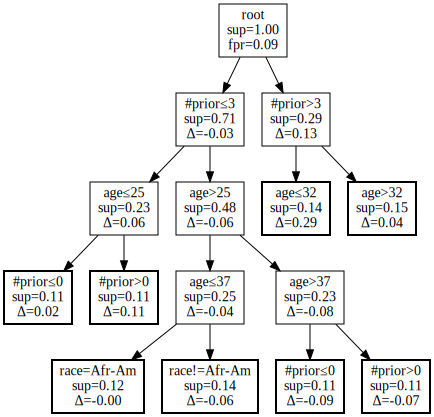

In [93]:
dot = tree_discr.trees.visualizeTreeDiGraph(abbreviations=abbreviations, all_info = False, show_condition=True)

suffix=f"{type_experiment}_{type_criterion}_sd_{min_support_tree}_{metric}"
saveFig = True

if saveFig:
    dot.render(
       os.path.join(tree_outputdir, f"tree_{suffix}")
                )
print(os.path.join(tree_outputdir, f"tree_{suffix}"))       
dot